In [3]:
import os
import numpy
from numpy import arange, sin, exp, pi, diff, floor, asarray
from scipy.io import savemat
from utils.simulation_utils import add_noise, quantize
from utils.gps_l1ca_utils import generate_GPS_L1CA_code
from utils.acquisition_utils import coarse_acquire
from utils.utils import PSKSignal, sample_sequence

import matplotlib.pyplot as plt

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
T_sim = 4                       # duration of simulated signal (s)
fs = 5e6                        # sampling rate (Hz)
N = int(T_sim * fs)
t = arange(N) / fs

f_carrier = 1.57542e9           # L1 carrier frequency (Hz)
f_center = 1.57542e9 - 1.25e6   # radio front-end center frequency (Hz)
f_inter = f_carrier - f_center  # intermediate frequency (Hz)
f_code = 1.023e6                # L1 C/A code rate (chips/s)

c = 299792458                   # speed of light (m/s)

In [6]:
G_flat = t * 0 - pi / (2 * pi * f_carrier / c)
G_step = .1 * (t > T_sim / 2)
G_linear = 0.5 * (t > T_sim / 2) * 3 * (t - T_sim / 2)
G_quadratic = 0.5 * (t >= T_sim / 2) * 2 * (t - T_sim / 2)**2
G_sinusoid = 0.5 * (exp((t - T_sim / 2)) * (t < T_sim / 2) + (t >= T_sim / 2)) * sin(2 * pi * 4 / T_sim * t)

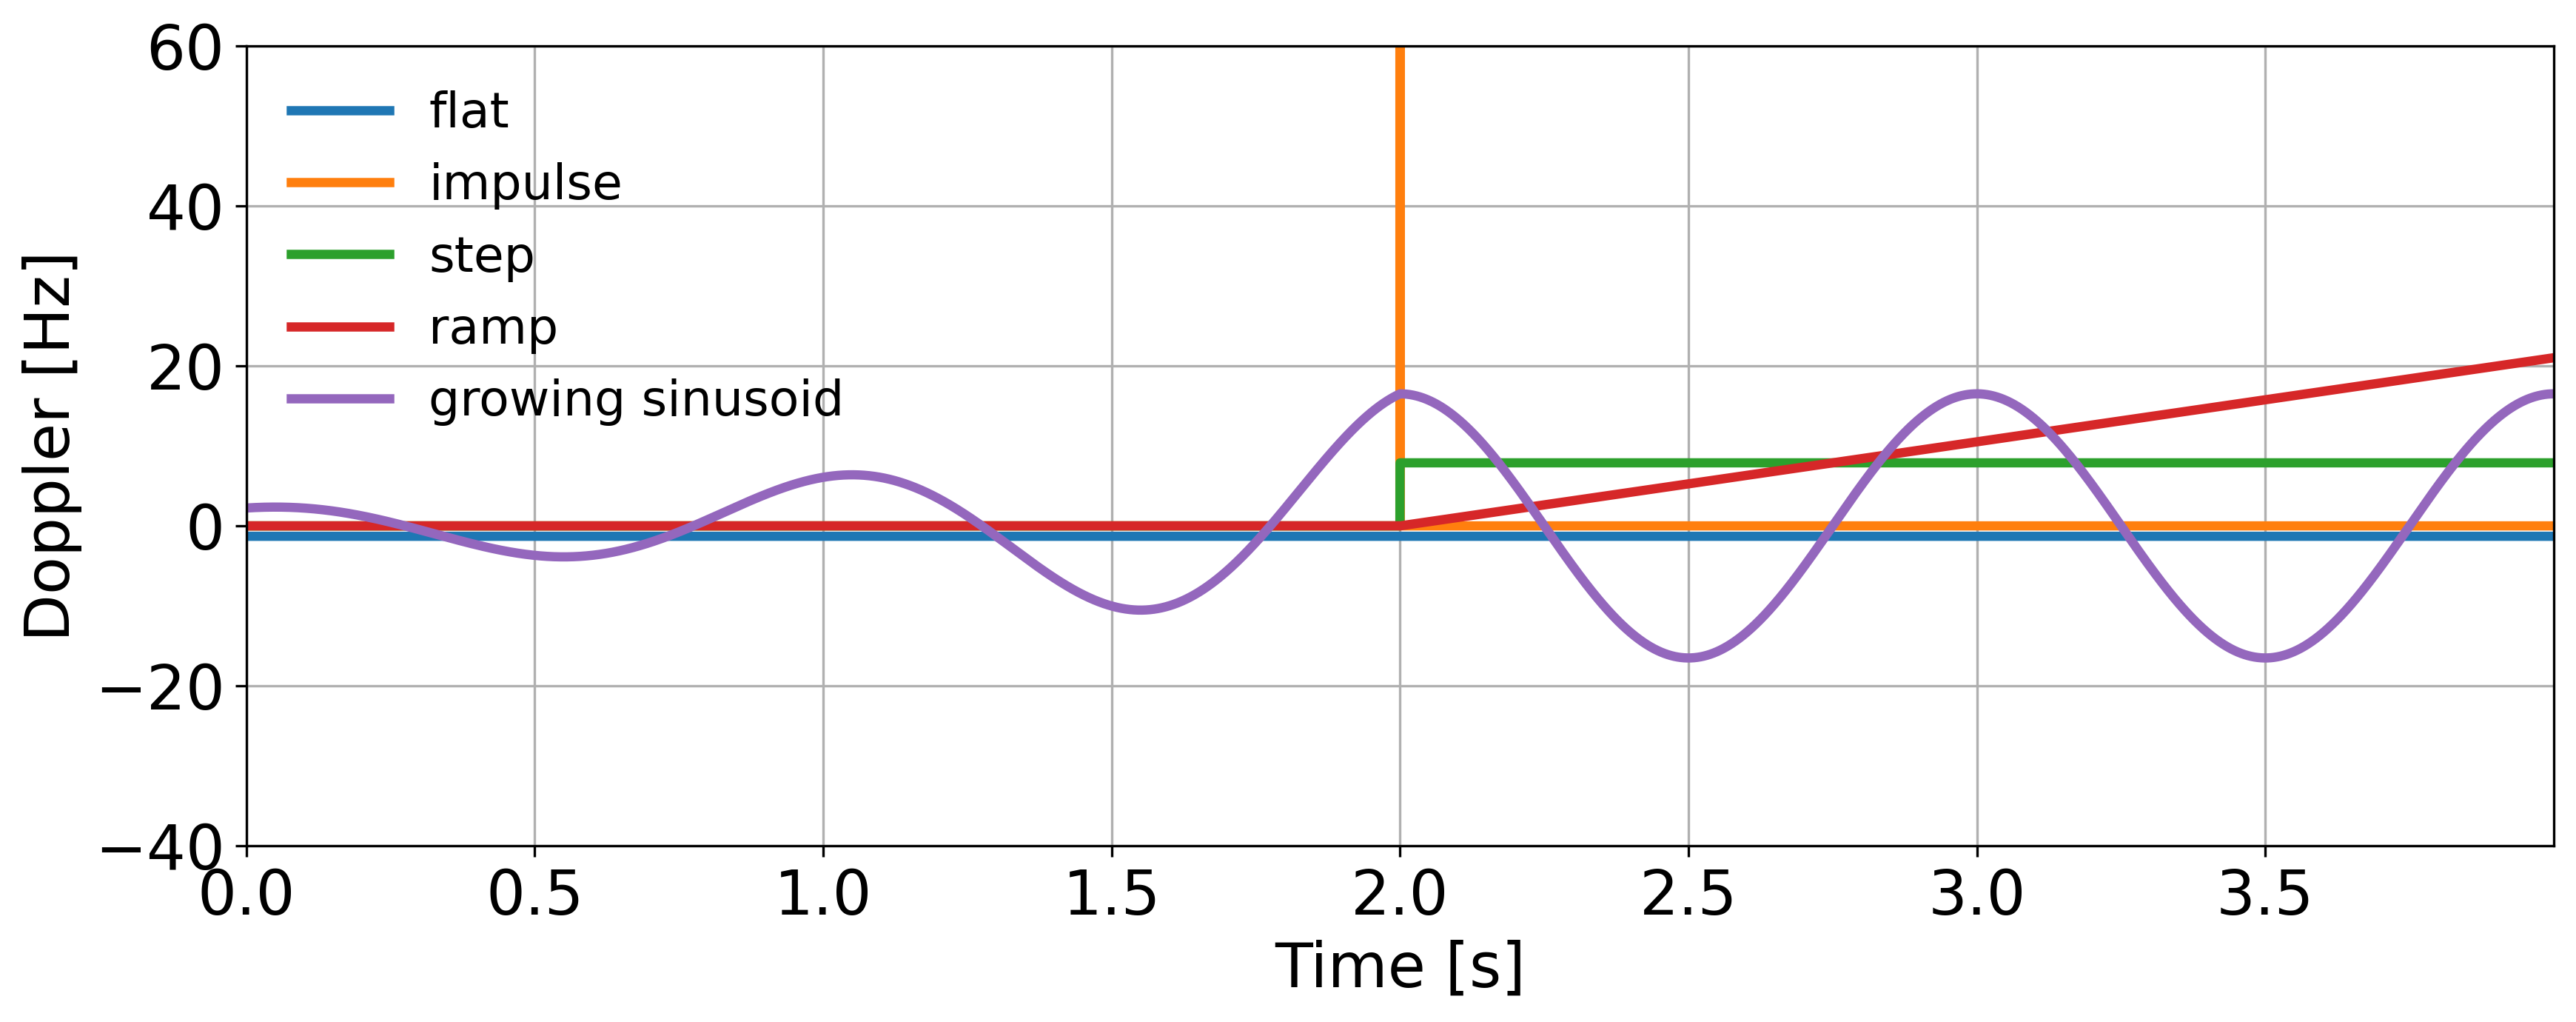

In [7]:
fig = plt.figure(figsize=(12, 5), dpi=300)
ax = fig.add_subplot(111)
skip = 1000
args = {'linewidth': 3}
ax.plot(t[:-1:skip], -1.3+diff(G_flat)[::skip] * fs * f_carrier / c, label='flat', **args)
ax.plot(t[:-1:skip], diff(G_step)[::skip] * fs * f_carrier / c, label='impulse', **args)
ax.plot(t[:-1:skip], diff(G_linear)[::skip] * fs * f_carrier / c, label='step', **args)
ax.plot(t[:-1:skip], diff(G_quadratic)[::skip] * fs * f_carrier / c, label='ramp', **args)
ax.plot(t[:-1:skip], diff(G_sinusoid)[::skip] * fs * f_carrier / c, label='growing sinusoid', **args)
ax.set_xlim(t[0], t[-1])
ax.set_ylim(-40, 60)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Doppler [Hz]')
ax.legend(loc=2, fontsize=16, frameon=False)
ax.grid()
plt.tight_layout()
plt.show()

In [8]:
prns = [4, 7, 10, 15, 29, 32]
n0s = [100, 1225, 2500, 4560, 2052.7846, 0.5]
tau0s = [n0 / fs for n0 in n0s]
fds = [1000, -1000, 2200, -3300, -3210, -4001]
Gs = [c * tau0 + c / f_carrier * fd * t + G for tau0, fd, G in zip(tau0s, fds, [G_flat, G_step, G_linear, G_quadratic, G_sinusoid, G_flat])]
cn0s = [45, 47, 49, 45, 41, 45 - 26 / 6 * t]

In [9]:
signal_samples = []
chips = []
for prn, G in zip(prns, Gs):
    code_seq = generate_GPS_L1CA_code(prn)
    
    chip = f_code * G / c
    code_samples = exp(1j * pi * code_seq[(floor(t * f_code + chip) % len(code_seq)).astype(int)])
    theta = 2 * pi * f_carrier * G / c
    samples = code_samples * exp(1j * (2 * pi * f_inter * t + theta))
    
    chips.append(chip)
    signal_samples.append(samples)

samples = add_noise(signal_samples, cn0s)
samples = quantize(samples, bits=2)

In [10]:
if not os.path.exists('../data'):
    os.makedirs('../data')
filepath = '../data/sim-RF_GPS-L1CA_5000_1250_complex_{0:02}s.mat'.format(T_sim)
savemat(filepath, {'samples': samples, 'chips': asarray(chips), 'prns': prns})